In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from zipfile import ZipFile

In [105]:
ZipFile('gan-getting-started.zip', 'r').extractall(path = 'images')

In [2]:
def normalize(arr):
    return arr.astype(np.float32)/127.5 - 1

def denormalize(arr):
    return ((arr + 1)*127.5).astype(np.uint8)

In [86]:
import random

In [207]:
class DataLoader:

    def __init__(self, paintings_dir, images_dir):
        self.paintings_dir = paintings_dir
        self.images_dir = images_dir
        self.data_extension_functions = {
            0 : (lambda image : image),
            1 : (lambda image : np.flip(image, 0)),
            2 : (lambda image : np.flip(image, 1)),
            3 : (lambda image : np.flip(np.flip(image, 0), 1)),
            4 : (lambda image : np.rot90(image)),
            5 : (lambda image : np.rot90(image, 3)),
            6 : (lambda image : np.flip(np.rot90(image), 0)),
            7 : (lambda image : np.flip(np.rot90(image), 1)),
            8 : (lambda image : np.flip(image, -1)),
            9 : (lambda image : np.flip(np.flip(image, 0), -1)),
            10 : (lambda image : np.flip(np.flip(image, 1), -1)),
            11 : (lambda image : np.flip(np.flip(np.flip(image, 0), 1), -1)),
            12 : (lambda image : np.flip(np.rot90(image), -1)),
            13 : (lambda image : np.flip(np.rot90(image, 3), -1)),
            14 : (lambda image : np.flip(np.flip(np.rot90(image), 0), -1)),
            15 : (lambda image : np.flip(np.flip(np.rot90(image), 1), -1))
        }
        self.indices = list(range(len(os.listdir(self.paintings_dir))*len(self.data_extension_functions)))

    def retrieve_batch(self, offset, batch_size):
        if(offset > len(self.indices)):
            raise Exception("Offset off limit.")
        elif((offset + batch_size) > len(self.indices)):
             return self.retrieve_images(batch_size), \
                selfretrieve_images(batch_size, ((offset + batch_size) - len(self.indices)), image_type = 'images')
        return self.retrieve_images(batch_size), \
            self.retrieve_images(batch_size, offset, image_type = 'images')
        
    def retrieve_images(self, batch_size, offset = 0, image_type = 'paintings'):
        dir_list = []
        dir = ''
        elem_nums = range(batch_size)
        result = np.zeros((batch_size, 256, 256, 3), dtype = np.float32)
        extension_func = self.data_extension_functions[0]
        if(image_type == 'paintings'):
            dir = self.paintings_dir
            dir_list = os.listdir(dir)
            random.shuffle(dir_list)            
        elif(image_type == 'images'):
            dir = self.images_dir
            dir_list = os.listdir(dir)
            elem_nums = self.indices[offset : offset + batch_size]
        for pos, elem in enumerate(elem_nums):
            if(image_type == 'paintings'):
               extension_func = self.data_extension_functions[random.randint(0, (len(self.data_extension_functions) - 1))] 
            result[pos] = normalize(extension_func(np.asarray(Image.open(dir +'/' + dir_list[elem]))))
        return result

    def shuffle(self):
        random.shuffle(self.indices)

In [168]:
data_loader = DataLoader('images/monet_jpg', 'images/photo_jpg')

In [173]:
paintings, photos  = data_loader.retrieve_batch(0, 24)

In [196]:
Image.fromarray(denormalize(paintings[0])).show()

In [176]:
Image.fromarray(denormalize(photos[0])).show()

In [172]:
data_loader.shuffle()

In [199]:
photos[0].dtype

dtype('float64')

In [200]:
image = np.asarray(Image.open('images/monet_jpg' +'/' + os.listdir('images/monet_jpg')[0]))
Image.fromarray(image).show()

In [201]:
image.dtype

dtype('uint8')

In [203]:
image = data_loader.data_extension_functions[0](image)

In [204]:
image.dtype

dtype('uint8')

In [206]:
normalize(image).dtype

dtype('float32')

In [177]:
import torch
import torch.nn as nn
import torch.optim as optim

In [208]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [178]:
class InstanceNormalization(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.layer = nn.InstanceNorm2d(num_features)

  def forward(self,x): 
    #print('x.shape:')
    #print(x.shape)
    if(x.shape[-1] == 1):
        result = nn.InstanceNorm2d(1)(x.reshape(x.shape[::-1]))
        return result.reshape(result.shape[::-1])
    return self.layer(x)

In [179]:
def downsample(in_channels, out_channels, kernel_size, norm_type = 'batchnorm', apply_norm = True):
  #initializer = tf.random_normal_initializer(0., 0.02)

  result = nn.Sequential()
  result.append(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, #padding='same',
                             padding = 1,
                             bias=False))
  if(apply_norm):
      if(norm_type.lower() == 'batchnorm'):
          result.append(nn.BatchNorm2d(out_channels))
      elif(norm_type.lower() == 'instancenorm'):          
          #result.append(nn.InstanceNorm2d(out_channels))
          result.append(InstanceNormalization(out_channels))

  result.append(nn.LeakyReLU(0.3))

  return result

In [180]:
def upsample(in_channels, out_channels, kernel_size, norm_type = 'batchnorm', apply_dropout = False):
  #initializer = tf.random_normal_initializer(0., 0.02)

  result = nn.Sequential()
  result.append(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2,
                                      #padding='same',
                                      padding=1,
                                      bias=False))
  
  if(norm_type.lower() == 'batchnorm'):
      result.append(nn.BatchNorm2d(out_channels))
  elif(norm_type.lower() == 'instancenorm'):          
      result.append(nn.InstanceNorm2d(out_channels))

  if apply_dropout:
    result.append(nn.Dropout())

  result.append(nn.ReLU())

  return result

In [181]:
class Generator(nn.Module):

    def __init__(self, output_channels, norm_type = 'batch_norm'):
        super(Generator, self).__init__()
        self.down_stack = [
            downsample(3, 64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
            downsample(64, 128, 4, norm_type),  # (bs, 64, 64, 128)
            downsample(128, 256, 4, norm_type),  # (bs, 32, 32, 256)
            downsample(256, 512, 4, norm_type),  # (bs, 16, 16, 512)
            downsample(512, 512, 4, norm_type),  # (bs, 8, 8, 512)
            downsample(512, 512, 4, norm_type),  # (bs, 4, 4, 512)
            downsample(512, 512, 4, norm_type),  # (bs, 2, 2, 512)
            downsample(512, 512, 4, norm_type),  # (bs, 1, 1, 512)
        ]
        self.up_stack = [
            upsample(512, 512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
            upsample(512, 512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
            upsample(512, 512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
            upsample(512, 512, 4, norm_type),  # (bs, 16, 16, 1024)
            upsample(512, 256, 4, norm_type),  # (bs, 32, 32, 512)
            upsample(256, 128, 4, norm_type),  # (bs, 64, 64, 256)
            upsample(128, 64, 4, norm_type),  # (bs, 128, 128, 128)
        ]
        self.last = nn.ConvTranspose2d(64, output_channels, 4, stride=2,
                                      #padding='same',
                                      padding=1,
                                      bias=False)

    def forward(self, z):
        x = z
        #i=0
        for down in self.down_stack:
            #print(i+1)
            x = down(x)
            #print(x.shape)
            #i+=1
        #i=0
        for up in self.up_stack:
            #print(i+1)            
            x = up(x)
            #print(x.shape)
            #i+=1
        return torch.tanh(self.last(x)) 

In [182]:
class Discriminator(nn.Module):

    def __init__(self, norm_type = 'batchnorm'):
        super(Discriminator, self).__init__()
        self.down_stack = [downsample(3, 64, 4, norm_type, False), 
                           downsample(64, 128, 4, norm_type, False),
                           downsample(128, 256, 4, norm_type, False)]
        self.model = nn.Sequential()
        self.model.append(nn.ZeroPad2d(1))
        self.model.append(nn.Conv2d(256, 512, 4, stride=1, bias = False))

        if(norm_type.lower() == 'batchnorm'):
            self.model.append(nn.BatchNorm2d(512))
        elif(norm_type.lower() == 'instancenorm'):          
            self.model.append(nn.InstanceNorm2d(512))

        self.model.append(nn.LeakyReLU())
        self.model.append(nn.ZeroPad2d(1))
        self.model.append(nn.Conv2d(512, 1, 4, stride=1))

    def forward(self, z):
        x= z
        #i = 0
        for down in self.down_stack:
            #print(i+1)
            x  = down(x)
            #print(x.shape)
            #i+=1
        return self.model(x)

In [213]:
#loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_obj = nn.BCEWithLogitsLoss()

In [184]:
def discriminator_loss(real, generated):
  #return (loss_obj(tf.ones_like(real), real) + loss_obj(tf.zeros_like(generated), generated)) * 0.5
  return (loss_obj(torch.ones_like(real), real) + loss_obj(torch.zeros_like(generated), generated)) * 0.5

In [185]:
def generator_loss(generated):
  #return loss_obj(tf.ones_like(generated), generated)
  return loss_obj(torch.ones_like(generated), generated)

In [186]:
LAMBDA = 10

In [214]:
def calc_cycle_loss(real_image, cycled_image):
  #return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * torch.mean(torch.abs(real_image - cycled_image))

In [215]:
def identity_loss(real_image, same_image):
  #return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * torch.mean(torch.abs(real_image - same_image))

In [209]:
OUTPUT_CHANNELS = 3

generator_g = Generator(OUTPUT_CHANNELS, norm_type='instancenorm').to(device)
generator_f = Generator(OUTPUT_CHANNELS, norm_type='instancenorm').to(device)

discriminator_x = Discriminator(norm_type='instancenorm').to(device)
discriminator_y = Discriminator(norm_type='instancenorm').to(device)

In [25]:
generator_optimizer = optim.Adam(generator_g.parameters() + generator_f.parameters(), lr = 2e-4, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator_x.parameters() + discriminator_y.parameters(), lr = 2e-4, betas=(0.5, 0.999))

In [26]:
generator_scaler = torch.amp.GradScaler()
discriminator_scaler = torch.amp.GradScaler()

C:\Users\User\AppData\Local\Temp\ipykernel_13364\1179951697.py:1: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  gen_g_scaler = torch.amp.GradScaler()
C:\Users\User\AppData\Local\Temp\ipykernel_13364\1179951697.py:2: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  gen_f_scaler = torch.amp.GradScaler()
C:\Users\User\AppData\Local\Temp\ipykernel_13364\1179951697.py:3: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  disc_x_scaler = torch.amp.GradScaler()
C:\Users\User\AppData\Local\Temp\ipykernel_13364\1179951697.py:4: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  disc_y_scaler = torch.amp.GradScaler()


In [210]:
def generate_images(model, test_input):
    #print(torch.from_numpy(test_input.reshape((1, 256, 256, 3))))
    prediction = model(torch.from_numpy(test_input.reshape((1, 3, 256, 256))).to(device)).cpu().detach().numpy().reshape((256, 256, 3))
    return Image.fromarray(denormalize(prediction))

In [211]:
sample_image = np.asarray(Image.open('images/photo_jpg/' + os.listdir('images/photo_jpg/')[4801]))
sample_image.shape

(256, 256, 3)

In [192]:
Image.fromarray(sample_image).show()

In [76]:
np.array([[1,2,3],[4,5,6],[7,8,9]], dtype = np.float32)*128 + 128

array([[ 256.,  384.,  512.],
       [ 640.,  768.,  896.],
       [1024., 1152., 1280.]], dtype=float32)

In [212]:
generated_image = generate_images(generator_g, normalize(sample_image))
generated_image.show()

In [412]:
discriminator_x(torch.from_numpy(normalize(np.asarray(generated_image).reshape(1, 3, 256, 256)))).shape

torch.Size([1, 1, 30, 30])

In [400]:
nn.InstanceNorm2d(1)(torch.empty(1, 1, 1, 512)).shape[::-1]

torch.Size([512, 1, 1, 1])

In [191]:
downsample(3, 64, 4, 'instance_norm', apply_norm=False)(torch.from_numpy(normalize(sample_image).reshape(3, 256, 256)))

tensor([[[ 4.8656e-03,  2.5610e-01,  4.7718e-01,  ...,  2.3901e-01,
           4.8804e-02, -4.2854e-02],
         [ 8.0845e-02, -9.3014e-02, -2.9490e-02,  ...,  3.7334e-02,
          -6.6095e-02, -2.1401e-02],
         [ 1.5201e-01,  6.8445e-02,  8.9556e-02,  ..., -5.9773e-03,
           2.3336e-01, -3.0203e-02],
         ...,
         [-1.3089e-01, -9.0241e-02, -5.0138e-02,  ..., -1.1922e-01,
          -1.4263e-01, -1.1744e-01],
         [-6.3550e-02, -9.5640e-02, -8.3755e-02,  ..., -4.6793e-02,
          -7.1219e-02, -3.8757e-02],
         [-1.0566e-01, -1.1123e-01, -8.4666e-02,  ..., -3.0207e-02,
           1.9253e-01, -6.3946e-03]],

        [[ 2.4183e-01,  1.7542e-01, -7.0656e-02,  ..., -2.3230e-02,
          -1.0918e-01,  9.1495e-02],
         [ 1.6454e-01, -3.2247e-02,  1.8232e-01,  ...,  8.2402e-02,
           3.9861e-01,  3.4429e-01],
         [-2.6800e-02,  3.5635e-01,  2.4050e-01,  ...,  2.7815e-01,
           2.3936e-01, -1.0481e-01],
         ...,
         [ 2.0898e-01, -3

In [216]:
def train_step(real_x, real_y):
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    with torch.amp.autocast(device_type = device.type):
        fake_y = generator_g(real_x)
        fake_x = generator_f(real_y)
        
        disc_real_x = discriminator_x(real_x)
        disc_real_y = discriminator_y(real_y)

        disc_fake_x = discriminator_x(fake_x.detach())
        disc_fake_y = discriminator_y(fake_y.detach())
        
        total_disc_loss = discriminator_loss(disc_real_x, disc_fake_x) + discriminator_loss(disc_real_y, disc_fake_y)

    discriminator_optimizer.zero_grad()
    discriminator_scaler.scale(total_disc_loss).backward()
    discriminator_scaler.step(discriminator_optimizer)
    discriminator_scaler.update()

    with torch.amp.autocast(device_type = device.type):
        fake_y = generator_g(real_x)
        cycled_x = generator_f(fake_y)

        fake_x = generator_f(real_y)
        cycled_y = generator_g(fake_x)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x)
        same_y = generator_g(real_y)
    
        disc_fake_x = discriminator_x(fake_x)
        disc_fake_y = discriminator_y(fake_y)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        total_generator_loss = total_gen_g_loss + total_gen_f_loss

    generator_optimizer.zero_grad()
    generator_scaler.scale(total_generator_loss).backward()
    generator_scaler.step(generator_optimizer)
    generator_scaler.update()

In [419]:
import time
from IPython.display import clear_output

In [420]:
batch_size = 24
num_of_batches = round(len(images)/batch_size) + (len(images)%batch_size>0)

In [429]:
for epoch in range(10):
  start = time.time()

  np.random.shuffle(indices)
  #n = 0    
  for i in range(0, num_of_batches):
    images_x, images_y = data_loader.retrieve_batch(i*batch_size, batch_size)
    print(images_x.dtype)
    print(images_y.dtype)
    train_step(torch.from_numpy(images_x).reshape(batch_size, 3, 256, 256), torch.from_numpy(images_y).reshape(batch_size, 3, 256, 256))
    if i % 25 == 0:
      print ('Epoch ' + str(epoch + 1) + '. ' + str((i+1)*batch_size) + ' records processed.')
    #n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_image) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, normalize(sample_image)).show()

  #if (epoch + 1) % 5 == 0:
  #  ckpt_save_path = ckpt_manager.save()
  #  print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         #ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

float32
float32


KeyboardInterrupt: 

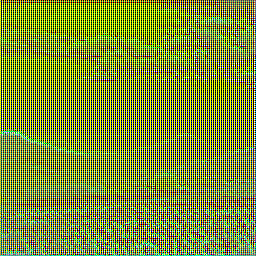

In [151]:
generate_images(generator_g, images['images_to_transform'][0])

In [45]:
images_x = torch.from_numpy(retrieve_batch(0, 24, indices, images['real_paintings'])).reshape(24, 3, 256, 256)
images_y = torch.from_numpy(retrieve_batch(0, 24, indices, images['images_to_transform'])).reshape(24, 3, 256, 256)
train_step(images_x, images_y)

fake and cycled
same
disc real nd fake
gen losses



KeyboardInterrupt



In [42]:
fake_y = generator_g(images_x)
cycled_x = generator_f(fake_y)

In [43]:
fake_x = generator_g(images_y)
cycled_y = generator_f(fake_x)